In [2]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

c:\Users\gerar\OneDrive\Desktop\alcoholSalesProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [ ]:
df = pd.read_csv('../data/preprocessed/dataset_ln.csv',index_col='DATE')
df.index = pd.DatetimeIndex(df.index,freq='MS')

df.head()

,SALES
DATE,
1992-01-01,8.148735
1992-02-01,8.148446
1992-03-01,8.294550
1992-04-01,8.425955
1992-05-01,8.347827


In [4]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)

    fig, ax = plt.subplots(figsize=(8, 5))

    train.plot(ax=ax, label="TRAIN")
    test.plot(ax=ax, label="TEST")
    y_pred.plot(ax=ax, label="PREDICTION")

    ax.set_title(f"{title}, MAE: {round(mae, 2)}")
    ax.legend()
    plt.show()

## Train test data splitting

We are going to use years 2018, 2017, and January 2019 as the test data and the rest as is going to be used as train

In [5]:
cutoff_dt = "2017-01-01"

train = df[df.index < cutoff_dt]
test = df[df.index >= cutoff_dt]

In [7]:
print(f"There are {len(train)} in the training dataset")
print(f"There are {len(test)} in the training dataset")

There are 300 in the training dataset
There are 25 in the training dataset


## Modeling

### Single Exponential Smoothing

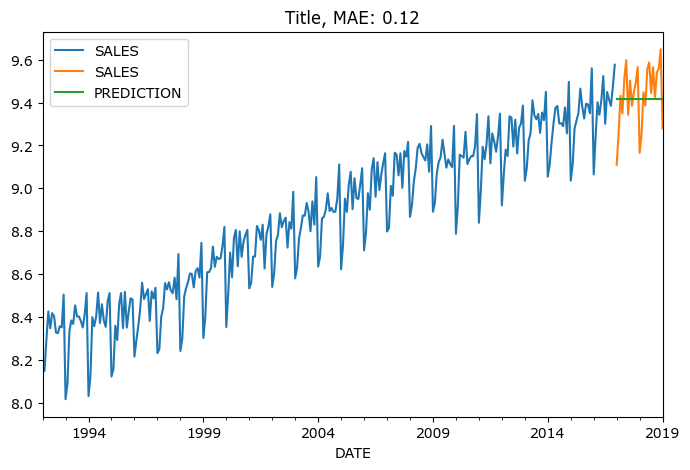

In [ ]:
hw = ExponentialSmoothing(train).fit()

pred = hw.predict(start='2017-01-01', end='2019-01-01')
plot_co2(train,test,pred,"Single Exponential Smoothing")

### Triple Exponential Smoothing

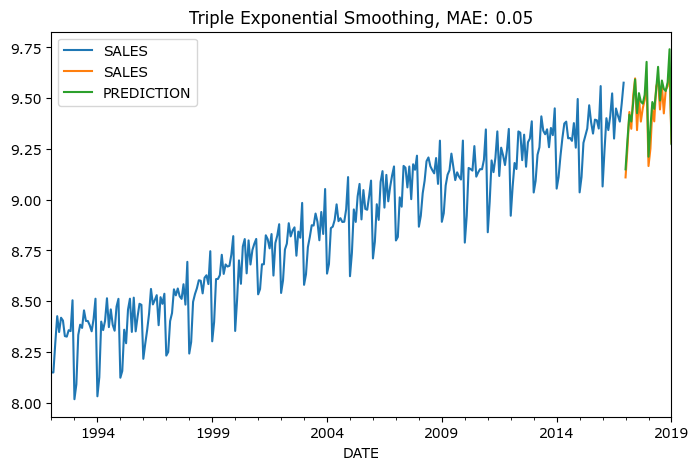

In [60]:
hw = ExponentialSmoothing(train, 
                          trend="add", 
                          seasonal="add", 
                          seasonal_periods=12).fit(smoothing_level=0.5, 
                                                   smoothing_trend=0.5, 
                                                   smoothing_seasonal=0.5)

pred = hw.predict(start='2017-01-01', end='2019-01-01')

plot_co2(train,test,pred,"Triple Exponential Smoothing")

### Prophet

#### Prophet Iteration 1

In [61]:
# First we will need to prepare the dataframe for prophet
train_prophet = train.reset_index()
train_prophet.columns = ["ds","y"]

m = Prophet()
m.fit(train_prophet,)

11:17:52 - cmdstanpy - INFO - Chain [1] start processing
11:17:52 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
# This line makes a dataframe with the dates to predict
future = m.make_future_dataframe(periods=25,freq='M')

# This uses the previous line to make the predictions
forecast = m.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

c:\Users\gerar\OneDrive\Desktop\alcoholSalesProject\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
320,2018-08-31,9.472859,9.419686,9.524841
321,2018-09-30,9.508914,9.454043,9.563736
322,2018-10-31,9.502638,9.447987,9.557225
323,2018-11-30,9.628806,9.575683,9.685107
324,2018-12-31,9.219959,9.163737,9.275026


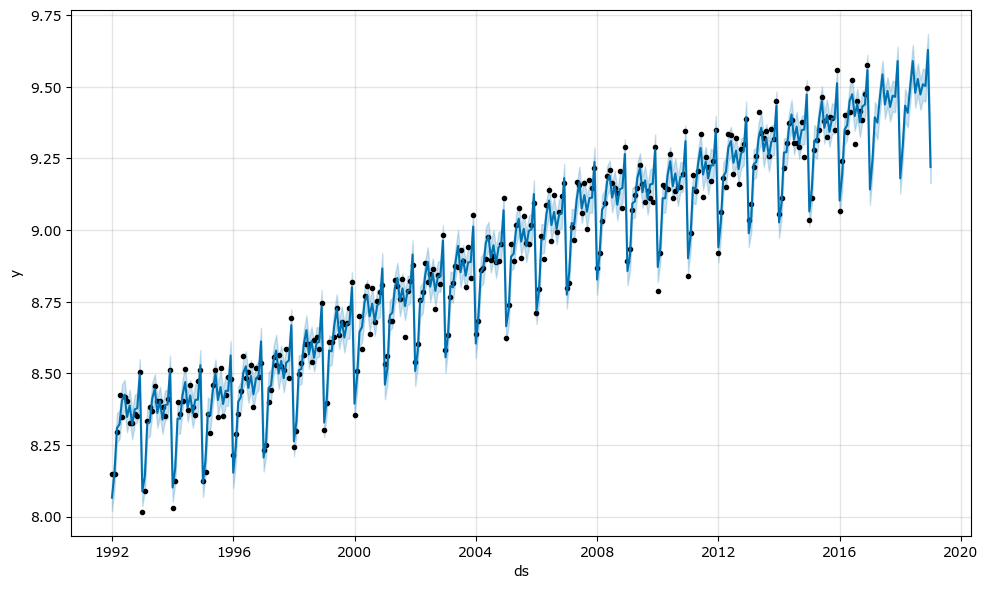

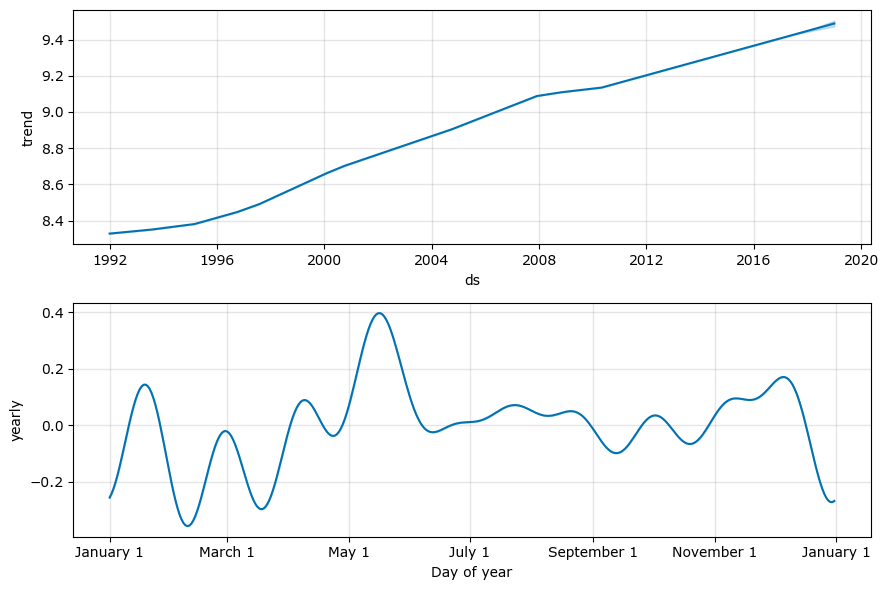

In [74]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

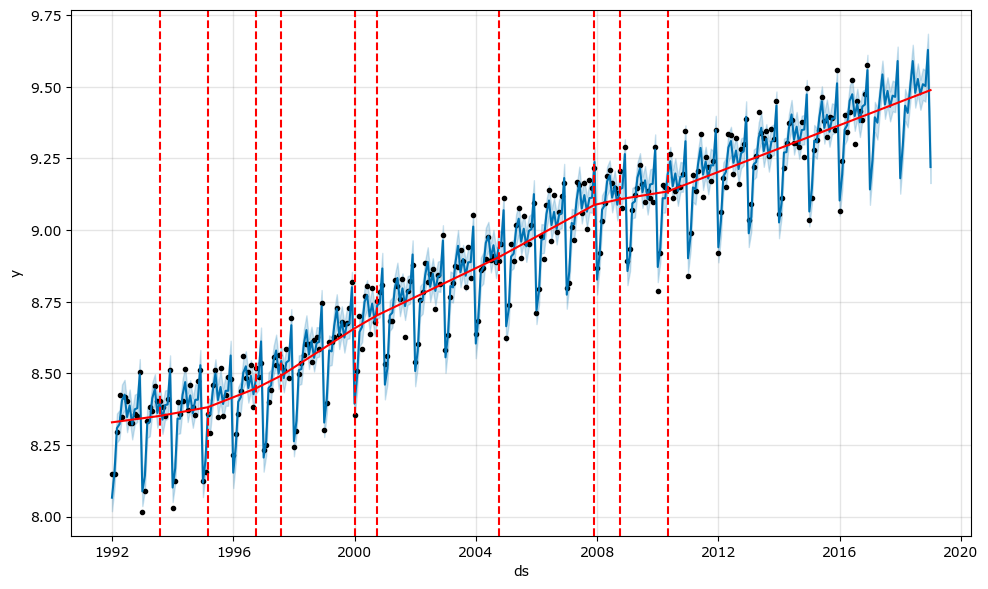

In [75]:
# Python
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


c:\Users\gerar\OneDrive\Desktop\alcoholSalesProject\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


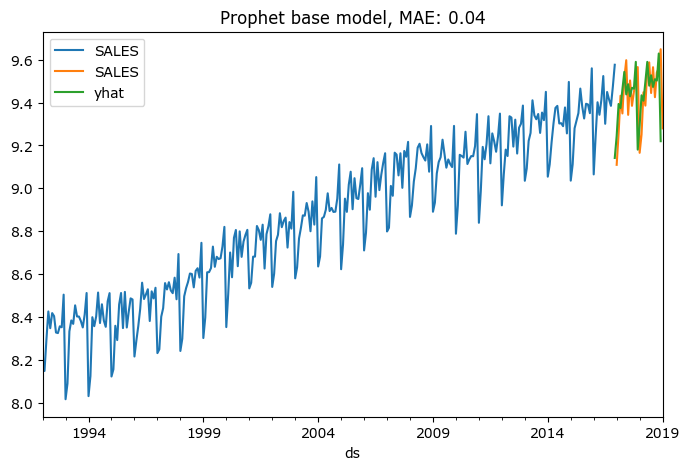

In [78]:
future = m.make_future_dataframe(periods=25,freq='M',include_history=False)
forecast = m.predict(future)

# Evaluation:
predicitons = forecast['yhat'].to_frame()
predicitons.index = pd.DatetimeIndex(forecast['ds'])

## MAE:
plot_co2(train,test,predicitons,"Prophet base model")

#### Prophet (Trend change points)

In [101]:
train_prophet = train.reset_index()
train_prophet.columns = ["ds","y"]

# Testing different changepoint priors:
changepoint_priors = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]
best_changepoint = 0
lowestMAE = 10

for changepoint in changepoint_priors:
    m = Prophet(
        changepoint_prior_scale=changepoint
    )

    m.fit(train_prophet)

    future = m.make_future_dataframe(periods=25,freq='ME',include_history=False)
    forecast = m.predict(future)

    # Evaluation:
    predicitons = forecast['yhat'].to_frame()
    predicitons.index = pd.DatetimeIndex(forecast['ds'])

    mae = mean_absolute_error(test, predicitons)

    if lowestMAE > mae:
        best_changepoint = changepoint
        lowestMAE = mae

print(f"The best changepoint is {best_changepoint} with MAE: {round(lowestMAE,3)}")

11:48:28 - cmdstanpy - INFO - Chain [1] start processing
11:48:28 - cmdstanpy - INFO - Chain [1] done processing
11:48:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:48:28 - cmdstanpy - INFO - Chain [1] start processing
11:48:28 - cmdstanpy - INFO - Chain [1] done processing
11:48:28 - cmdstanpy - INFO - Chain [1] start processing
11:48:28 - cmdstanpy - INFO - Chain [1] done processing
11:48:28 - cmdstanpy - INFO - Chain [1] start processing
11:48:29 - cmdstanpy - INFO - Chain [1] done processing
11:48:29 - cmdstanpy - INFO - Chain [1] start processing
11:48:29 - cmdstanpy - INFO - Chain [1] done processing
11:48:29 - cmdstanpy - INFO - Chain [1] start processing
11:48:29 - cmdstanpy - INFO - Chain [1] done processing
11:48:29 - cmdstanpy - INFO - Chain [1] start processing
11:48:29 - cmdstanpy - INFO - Chain [1] done processing
11:48:29 - cmdstanpy - INFO - Chain [1] start process

The best changepoint is 0.001 with MAE: 0.034


11:48:32 - cmdstanpy - INFO - Chain [1] start processing
11:48:32 - cmdstanpy - INFO - Chain [1] done processing


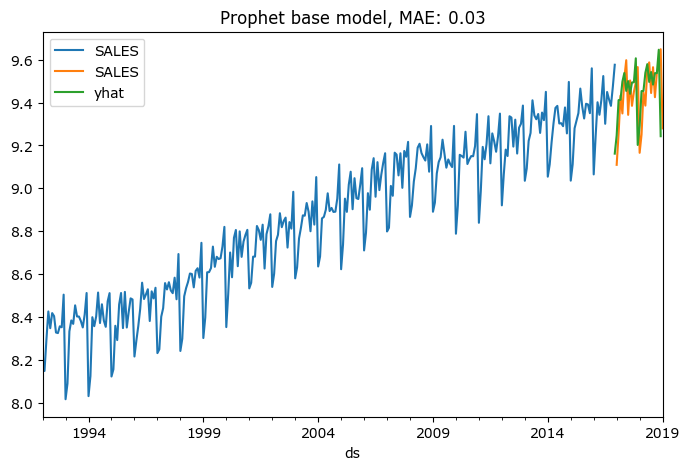

In [102]:
m = Prophet(
    changepoint_prior_scale=best_changepoint
)

m.fit(train_prophet)

future = m.make_future_dataframe(periods=25,freq='ME',include_history=False)
forecast = m.predict(future)

# Evaluation:
predicitons = forecast['yhat'].to_frame()
predicitons.index = pd.DatetimeIndex(forecast['ds'])

## MAE:
plot_co2(train,test,predicitons,"Prophet base model")

In [103]:
future = m.make_future_dataframe(periods=25,freq='M')

forecast = m.predict(future)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

c:\Users\gerar\OneDrive\Desktop\alcoholSalesProject\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
320,2018-08-31,9.484148,9.421762,9.544846
321,2018-09-30,9.537219,9.476933,9.598386
322,2018-10-31,9.537519,9.476355,9.592989
323,2018-11-30,9.646414,9.586292,9.705567
324,2018-12-31,9.243208,9.184766,9.307699


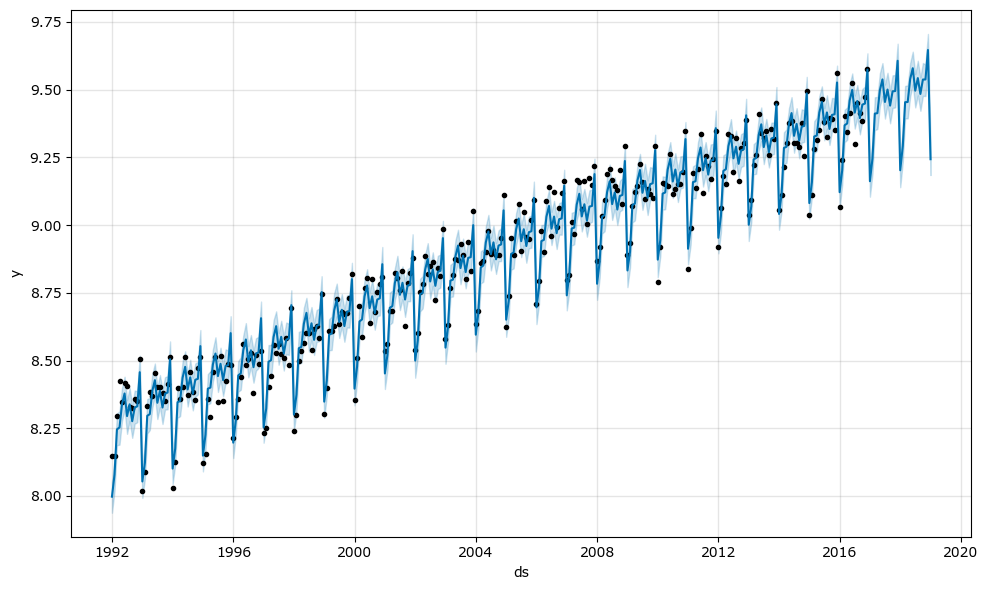

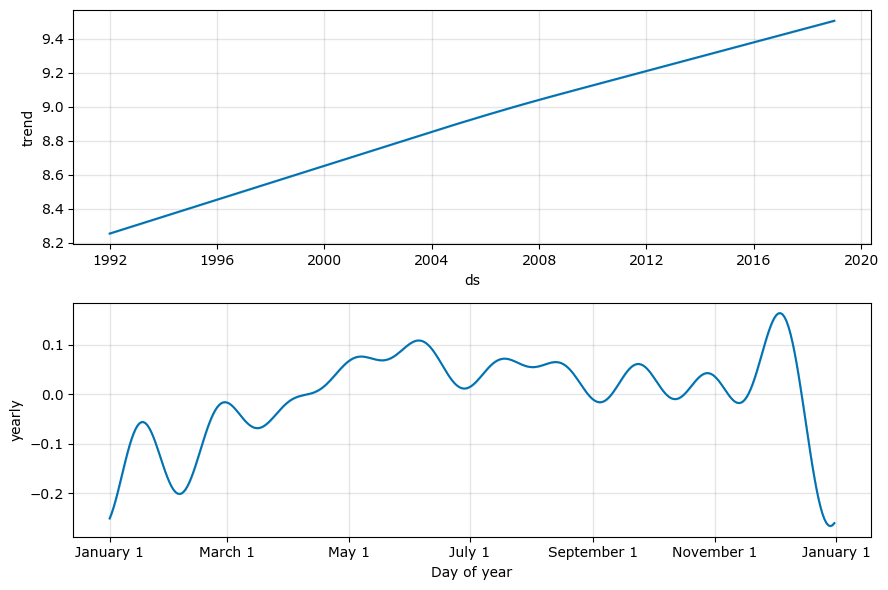

In [104]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)